<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
#!pip install watermark
%load_ext watermark

In [ ]:
#!pip install numpy scipy pandas matplotlib seaborn plotly statsmodels sklearn --upgrade

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.9
IPython 5.5.0

numpy 1.19.2
scipy 1.5.2
pandas 1.1.2
matplotlib 3.3.2
statsmodels 0.12.0
sklearn 0.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :


In [ ]:
#%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.6.1
IPython 5.3.0

numpy 1.13.3
scipy 0.19.0
pandas 0.20.1
matplotlib 2.1.0
statsmodels 0.8.0
sklearn 0.19.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)
system     : Darwin
release    : 16.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : ca8e6e4e47061a4c44a8506c9741b1c65fc9249a


In [3]:
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
sns.set()

In [4]:
# Поменяйте на свой путь к данным
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    PATH_TO_DATA = '/content/drive/My Drive/ML\DS/Yandex_MIPT_coursera/Course6/Final1/capstone_user_identification/'
else:
    PATH_TO_DATA = 'capstone_user_identification/'

Mounted at /content/drive


## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [10]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [12]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [13]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=100, n_jobs=-1)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
cv_acc = np.mean(cv_scores)

In [ ]:
predictions = knn.predict(X_valid)
val_acc = accuracy_score(y_valid, predictions)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [14]:
def write_answer(name, answers):
    with open(name, 'w') as f:
        ans = list(map(lambda x: str(round(x, 3)), answers))
        f.write(' '.join(ans)) 

In [ ]:
answers = [cv_acc, val_acc]
print(f'Accuracy on cross-validation: {round(cv_acc, 3)}')
print(f'Accuracy on validation set: {round(val_acc, 3)}')

Accuracy on cross-validation: 0.559
Accuracy on validation set: 0.584


In [ ]:
write_answer('1.txt', answers)

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
forest = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=17, n_jobs=-1)
forest.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=17)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [ ]:
predictions = forest.predict(X_valid)
val_acc = accuracy_score(y_valid, predictions)

In [ ]:
answers = [forest.oob_score_, val_acc]
print(f'Random forest oob score: {round(forest.oob_score_, 3)}')
print(f'Accuracy on validation set: {round(val_acc, 3)}')

Random forest oob score: 0.717
Accuracy on validation set: 0.731


In [ ]:
write_answer('2.txt', answers)

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [15]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [16]:
logit = LogisticRegression(solver='liblinear', random_state=17)
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
cv_scores = cross_val_score(logit, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
cv_acc = np.mean(cv_scores)

In [18]:
predictions = logit.predict(X_valid)
val_acc = accuracy_score(y_valid, predictions)

In [19]:
print(f'Accuracy on cross-validation: {round(cv_acc, 3)}')
print(f'Accuracy on validation set: {round(val_acc, 3)}')

Accuracy on cross-validation: 0.763
Accuracy on validation set: 0.782


**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [20]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, cv=skf, scoring='accuracy',
                                            multi_class='multinomial', random_state=17,
                                            n_jobs=-1) 
logit_grid_searcher1.fit(X_train, y_train)

CPU times: user 2.94 s, sys: 3.58 s, total: 6.51 s
Wall time: 27.8 s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [21]:
# We can take any value from scores_ because of multinomial option
cv_scores = list(logit_grid_searcher1.scores_.values())[0]
logit_mean_cv_scores1 = cv_scores.mean(axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [22]:
max_index = np.argmax(logit_mean_cv_scores1)
best_C = logit_c_values1[max_index]
best_acc = logit_mean_cv_scores1[max_index]
print(f'Best C = {round(best_C, 5)}')
print(f'Best cross-validation accuracy = {round(best_acc, 5)}')

Best C = 1.0
Best cross-validation accuracy = 0.76123


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [23]:
import plotly.express as px
fig = px.line(x=logit_c_values1, y=logit_mean_cv_scores1, log_x=True, width=800, height=500,
              labels={'x': 'Cs',
                      'y': 'Accuracy'},
              title='Cross-validation Accuracy')
fig.update_traces(mode='lines+markers')
fig.update_layout(title=dict(x=0.5))
fig.show()

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [24]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(Cs=logit_c_values2, cv=skf, scoring='accuracy',
                                            multi_class='multinomial', random_state=17,
                                            n_jobs=-1)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 2.82 s, sys: 3.13 s, total: 5.94 s
Wall time: 1min 14s


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [25]:
# We can take any value from scores_ because of multinomial option
cv_scores = list(logit_grid_searcher2.scores_.values())[0]
logit_mean_cv_scores2 = cv_scores.mean(axis=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [29]:
max_index = np.argmax(logit_mean_cv_scores2)
best_C_logit = logit_c_values2[max_index]
best_acc = logit_mean_cv_scores2[max_index]
print(f'Best C = {round(best_C_logit, 5)}')
print(f'Best cross-validation accuracy = {round(best_acc, 5)}')

Best C = 1.91579
Best cross-validation accuracy = 0.76143


In [74]:
logit_grid_searcher2.scores_[31].argmax()
np.unravel_index(45, (3, 20))
logit_grid_searcher2.Cs_[5]

1.9157894736842107

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [27]:
fig = px.line(x=logit_c_values2, y=logit_mean_cv_scores2, width=800, height=500,
              labels={'x': 'Cs',
                      'y': 'Accuracy'},
              title='Cross-validation Accuracy')
fig.update_traces(mode='lines+markers')
fig.update_layout(title=dict(x=0.5))
fig.show()

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

In [28]:
predictions = logit_grid_searcher2.predict(X_valid)
logit_cv_acc = accuracy_score(y_valid, predictions)
print(f'Validation set accuracy: {round(logit_cv_acc, 5)}')

Validation set accuracy: 0.77957


**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
answers = [best_acc, logit_cv_acc]
write_answer('3.txt', answers)
print(f'Accuracy on cross-validation: {round(best_acc, 3)}')
print(f'Accuracy on validation set: {round(logit_cv_acc, 3)}')

Accuracy on cross-validation: 0.761
Accuracy on validation set: 0.78


**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [86]:
from sklearn.svm import LinearSVC

In [87]:
svm = LinearSVC(C=1, random_state=17)
svm.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
          verbose=0)

In [ ]:
cv_scores = cross_val_score(svm, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=-1)
cv_acc = cv_scores.mean()

In [ ]:
predictions = svm.predict(X_valid)
val_acc = accuracy_score(y_valid, predictions)

In [ ]:
print(f'Accuracy on cross-validation: {round(cv_acc, 3)}')
print(f'Accuracy on validation set: {round(val_acc, 3)}')

Accuracy on cross-validation: 0.751
Accuracy on validation set: 0.777


**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [ ]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1, scoring='accuracy',
                                  cv=skf, return_train_score=True, n_jobs=-1)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 2.34 s, sys: 5.44 ms, total: 2.34 s
Wall time: 12.9 s


/home/snake/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             estimator=LinearSVC(C=1, random_state=17), n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             return_train_score=True, scoring='accuracy')

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [ ]:
best_C = svm_grid_searcher1.best_params_['C']
best_acc = svm_grid_searcher1.best_score_
print(f'Best C = {round(best_C, 5)}')
print(f'Best cross-validation accuracy = {round(best_acc, 5)}')

Best C = 5555.5556
Best cross-validation accuracy = 0.696


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

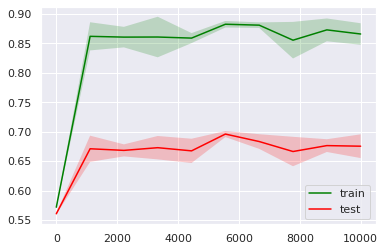

In [ ]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [88]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 = GridSearchCV(svm, param_grid=svm_params2, scoring='accuracy',
                                  cv=skf, return_train_score=True, n_jobs=-1)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 1.35 s, sys: 81.6 ms, total: 1.43 s
Wall time: 1min 33s


Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [ ]:
best_C = svm_grid_searcher2.best_params_['C']
best_acc = svm_grid_searcher2.best_score_
print(f'Best C = {round(best_C, 5)}')
print(f'Best cross-validation accuracy = {round(best_acc, 5)}')

Best C = 0.10434
Best cross-validation accuracy = 0.76702


Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

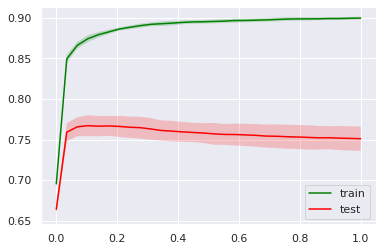

In [ ]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [ ]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
answers = [best_acc, svm_cv_acc]
write_answer('4.txt', answers)
print(f'Accuracy on cross-validation: {round(best_acc, 3)}')
print(f'Accuracy on validation set: {round(svm_cv_acc, 3)}')

Accuracy on cross-validation: 0.767
Accuracy on validation set: 0.781


## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [ ]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    start_time = time()
    
    with open(path_to_X_pickle, 'rb') as fx:
        X = pickle.load(fx)
        
    with open(path_to_y_pickle, 'rb') as fy:
        y = pickle.load(fy)
        
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=random_state,
                                                        stratify=y)
    
    cv_scores = cross_val_score(estimator, X_train, y_train, cv=cv, n_jobs=-1)
    cv_accuracy = cv_scores.mean()
    
    estimator.fit(X_train, y_train)
    predictions = estimator.predict(X_valid)
    val_accuracy = accuracy_score(y_valid, predictions)
    
    return cv_accuracy, val_accuracy, '%.2f sec' % (time() - start_time)

**Убедитесь, что функция работает.**

In [ ]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w10.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users_s15_w10.pkl'), skf, random_state=17, test_size=0.3)

(0.8243252292702751, 0.8404835269021095, '1.43 sec')

In [ ]:
print('Cross-val acc. = {0:.5f}; Validation set acc. = {1}; Elapsed time = {2}' \
      .format(*model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w10.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users_s15_w10.pkl'), skf, random_state=17, test_size=0.3)))

Cross-val acc. = 0.82433; Validation set acc. = 0.8404835269021095; Elapsed time = 1.39 sec


**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [ ]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        X_file_name = f'X_sparse_10users_s{session_length}_w{window_size}.pkl'
        y_file_name = f'y_10users_s{session_length}_w{window_size}.pkl'
        path_to_X_pkl = os.path.join(PATH_TO_DATA, X_file_name)
        path_to_y_pkl = os.path.join(PATH_TO_DATA, y_file_name)
        print(f'Session length = {session_length}')
        print(f'Window size = {window_size}')
        print('Cross-val acc. = {0:.5f}; Validation set acc. = {1:.5f}; Elapsed time = {2}' \
              .format(*model_assessment(svm_grid_searcher2.best_estimator_, 
                                        path_to_X_pkl, path_to_y_pkl, skf,
                                        random_state=17, test_size=0.3)))
        print('_' * 20)

Session length = 15
Window size = 10
Cross-val acc. = 0.82433; Validation set acc. = 0.84048; Elapsed time = 1.45 sec
____________________
Session length = 10
Window size = 10
Cross-val acc. = 0.76702; Validation set acc. = 0.78075; Elapsed time = 0.79 sec
____________________
Session length = 15
Window size = 7
Cross-val acc. = 0.84950; Validation set acc. = 0.85432; Elapsed time = 2.07 sec
____________________
Session length = 10
Window size = 7
Cross-val acc. = 0.79836; Validation set acc. = 0.80737; Elapsed time = 1.19 sec
____________________
Session length = 7
Window size = 7
Cross-val acc. = 0.75477; Validation set acc. = 0.76174; Elapsed time = 0.70 sec
____________________
Session length = 15
Window size = 5
Cross-val acc. = 0.86704; Validation set acc. = 0.87530; Elapsed time = 2.83 sec
____________________
Session length = 10
Window size = 5
Cross-val acc. = 0.81775; Validation set acc. = 0.82456; Elapsed time = 1.56 sec
____________________
Session length = 7
Window size = 

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
X_file_path = os.path.join(PATH_TO_DATA, 'X_sparse_10users_s15_w5.pkl')
y_file_path = os.path.join(PATH_TO_DATA, 'y_10users_s15_w5.pkl')

cv_acc, val_acc, _ = model_assessment(svm_grid_searcher2.best_estimator_, 
                                      X_file_path, y_file_path, skf,
                                      random_state=17, test_size=0.3)

answers = [cv_acc, val_acc]
write_answer('5.txt', answers)
print(f'Cross-val acc. = {cv_acc:.5f}; Validation set acc. = {val_acc:.5f}')

Cross-val acc. = 0.86704; Validation set acc. = 0.87530


**Прокомментируйте полученные результаты.** 

Для результатов исследования 10 пользователей есть некая закономерность, по которой изменяется доля неправильных ответов. Если зафиксировать ширину окна, а длину сессии увеличивать, то качество увеличивается. Если зафиксировать длину сессии, а ширину окна уменьшать, то качество также увеличивается.

**Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :)**

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    X_file_name = f'X_sparse_150users_s{session_length}_w{window_size}.pkl'
    y_file_name = f'y_150users_s{session_length}_w{window_size}.pkl'
    path_to_X_pkl = os.path.join(PATH_TO_DATA, X_file_name)
    path_to_y_pkl = os.path.join(PATH_TO_DATA, y_file_name)
    print(f'Session length = {session_length}')
    print(f'Window size = {window_size}')
    print('Cross-val acc. = {0:.5f}; Validation set acc. = {1:.5f}; Elapsed time = {2}' \
          .format(*model_assessment(estimator, 
                                    path_to_X_pkl, path_to_y_pkl, skf,
                                    random_state=17, test_size=0.3)))
    print('_' * 20)

Session length = 5
Window size = 5
Cross-val acc. = 0.40836; Validation set acc. = 0.42172; Elapsed time = 180.03 sec
____________________
Session length = 7
Window size = 7
Cross-val acc. = 0.43665; Validation set acc. = 0.45296; Elapsed time = 167.72 sec
____________________
Session length = 10
Window size = 10
Cross-val acc. = 0.46308; Validation set acc. = 0.48363; Elapsed time = 145.28 sec
____________________
CPU times: user 4min 21s, sys: 241 ms, total: 4min 21s
Wall time: 8min 13s


Для 150 пользователей качество растёт с ростом длины сессии и ширины окна. 

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
X_file_path = os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl')
y_file_path = os.path.join(PATH_TO_DATA, 'y_150users.pkl')

cv_acc, val_acc, _ = model_assessment(estimator, 
                                      X_file_path, y_file_path, skf,
                                      random_state=17, test_size=0.3)

answers = [cv_acc, val_acc]
write_answer('6.txt', answers)
print(f'Cross-val acc. = {cv_acc:.5f}; Validation set acc. = {val_acc:.5f}')

Cross-val acc. = 0.46308; Validation set acc. = 0.48363


## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [6]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [7]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [ ]:
%%time
logit_cv_150users = LogisticRegressionCV(Cs=[logit_grid_searcher2.Cs_[10]], cv=skf, multi_class='ovr',
                                         random_state=17, n_jobs=-1, scoring='accuracy')
logit_cv_150users.fit(X_train_150, y_train_150)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [76]:
cv_scores_by_user = {}
for user_id, scores in logit_cv_150users.scores_.items():
    cv_scores_by_user[user_id] = scores.mean()
    print('User {user}, CV score: {mean_score:.5f}'.format(user=user_id, mean_score=scores.mean()))

User 6, CV score: 0.99611
User 13, CV score: 0.99636
User 15, CV score: 0.99528
User 16, CV score: 0.99179
User 28, CV score: 0.99036
User 31, CV score: 0.99417
User 33, CV score: 0.99372
User 39, CV score: 0.98583
User 46, CV score: 0.99797
User 49, CV score: 0.99531
User 50, CV score: 0.99429
User 53, CV score: 0.99359
User 65, CV score: 0.99688
User 66, CV score: 0.99479
User 82, CV score: 0.99632
User 85, CV score: 0.99638
User 89, CV score: 0.99071
User 92, CV score: 0.99440
User 100, CV score: 0.99444
User 102, CV score: 0.99120
User 103, CV score: 0.98066
User 105, CV score: 0.99695
User 106, CV score: 0.99484
User 118, CV score: 0.99100
User 119, CV score: 0.99658
User 120, CV score: 0.99432
User 126, CV score: 0.99505
User 127, CV score: 0.99160
User 128, CV score: 0.98462
User 138, CV score: 0.99698
User 158, CV score: 0.99705
User 160, CV score: 0.99679
User 165, CV score: 0.99733
User 172, CV score: 0.99650
User 177, CV score: 0.99676
User 203, CV score: 0.99763
User 207, C

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [77]:
class_distr = np.bincount(y_train_150.astype('int'))
acc_diff_vs_constant = {}
for user_id in np.unique(y_train_150):
    proportion = (len(y_train_150) - class_distr[user_id]) / len(y_train_150)
    acc_diff_vs_constant[user_id] = cv_scores_by_user[user_id] - proportion

In [78]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()
num_better_than_default

122

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [79]:
better_proportion = num_better_than_default / 150
answers = [better_proportion]
write_answer('7.txt', answers)
print(f'Proportion of users that have better than constant predictions = {better_proportion:.3f}')

Proportion of users that have better than constant predictions = 0.813


**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [91]:
y_binary_128 = (y_150users == 128).astype(int)

In [84]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [94]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_

n_train, val_train, val_test = learning_curve(estimator, X_sparse_150users, y_binary_128,
                                              train_sizes=train_sizes,
                                              cv=skf, scoring='accuracy', n_jobs=-1,
                                              random_state=17)

CPU times: user 1.21 s, sys: 81.9 ms, total: 1.3 s
Wall time: 17.3 s


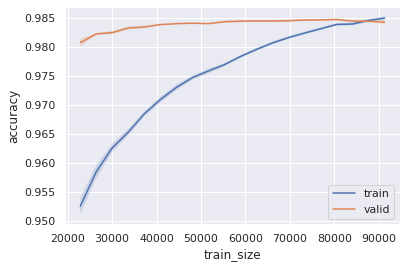

In [95]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

С увеличением тренировочной выборки увеличивается каечство на тренировке. Также увеличивается качество на валидации, но начинает уменьшаться, когда доля тренировочной выборки приближается к 1. Это может происходить, потому что очень мало данных остаётся для валидации. Большее количество данных поможет классификатору получить большую точность на тренировочном множестве, но это можт привести к переобучению 

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.